# Clustering of Image with Imagebind LLM Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Aagam0812/DataMining/blob/main/Assignment10/ImagebindLLM.ipynb)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

Cloning into 'ImageBind'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 112 (delta 43), reused 33 (delta 33), pack-reused 51
Receiving objects: 100% (112/112), 2.64 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (50/50), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-req-build-t0yjcge1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-t0yjcge1
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a

In [1]:
%cd /content/ImageBind


/content/ImageBind


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.cluster import KMeans
from random import sample

from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType


# Setup for Imagebind
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add additional transforms if needed
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


100%|██████████| 4.47G/4.47G [00:29<00:00, 163MB/s]


In [4]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/gdrive/MyDrive/DataMining/Satellite_images.zip'

# Directory where we'll extract the files
extraction_path = '/content/gdrive/MyDrive/DataMining/extracted_Satellite_dataset'

# Creating the directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Listing the contents of the extracted folder
extracted_files = os.listdir(extraction_path)
extracted_files.sort()
extracted_files


['data']

In [7]:
# Assuming data_path is the path to your dataset folder
data_path = '/content/gdrive/MyDrive/DataMining/extracted_Satellite_dataset/data'
categories = ['cloudy', 'desert', 'green_area', 'water']  # Adjust categories as per your dataset


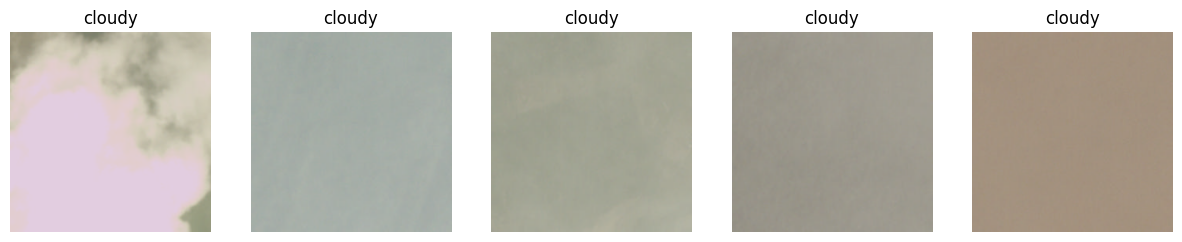

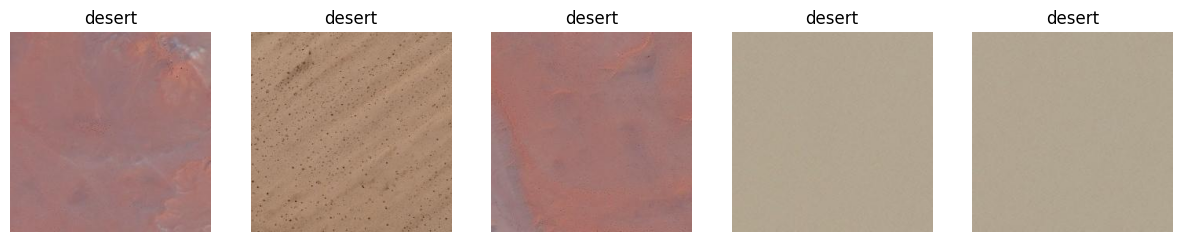

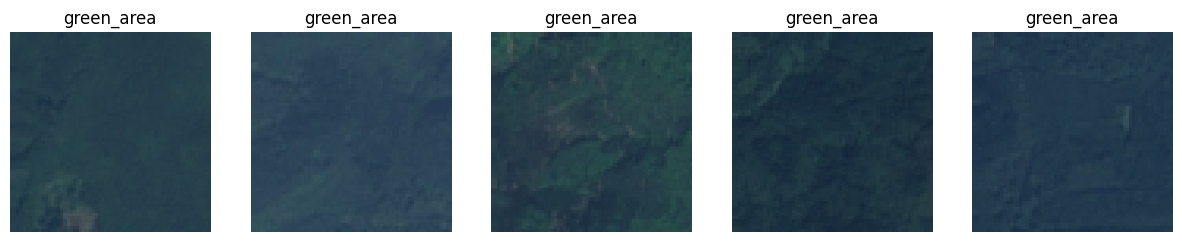

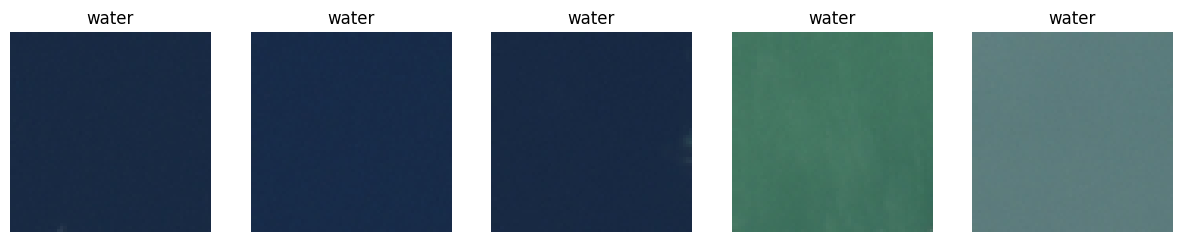

In [8]:
# Function to display images
def display_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(image_paths[:num_images]):
        plt.subplot(1, num_images, i + 1)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Displaying a few images from each category
for category in categories:
    folder_path = os.path.join(data_path, category)
    image_files = os.listdir(folder_path)
    image_paths = [os.path.join(folder_path, file) for file in image_files]
    display_images(image_paths, category)


In [43]:
# Function to load and transform an image
def load_and_transform_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB
    image = transform(image)
    return image.unsqueeze(0).to(device)  # Add batch dimension and send to device
 # Add batch dimension and send to device

# Load and transform images, then generate embeddings
image_paths = []  # To keep track of image paths for visualization
image_embeddings = []
for category in categories:
    folder_path = os.path.join(data_path, category)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = load_and_transform_image(image_path)
        with torch.no_grad():
            output = model({ModalityType.VISION: image})
            embedding = output[ModalityType.VISION]  # Ensure this extracts the embedding correctly
            image_embeddings.append(embedding.cpu().numpy())
            image_paths.append(image_path)

# Convert the list of embeddings to a numpy array
image_embeddings = np.vstack(image_embeddings)

In [44]:
from sklearn.cluster import KMeans

num_clusters = len(categories)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(image_embeddings)
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
import random

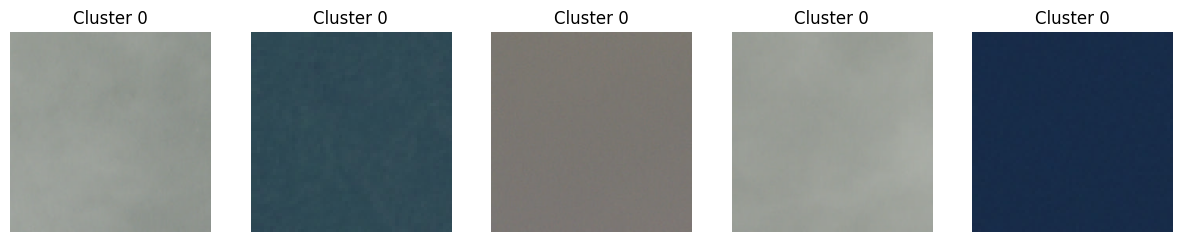

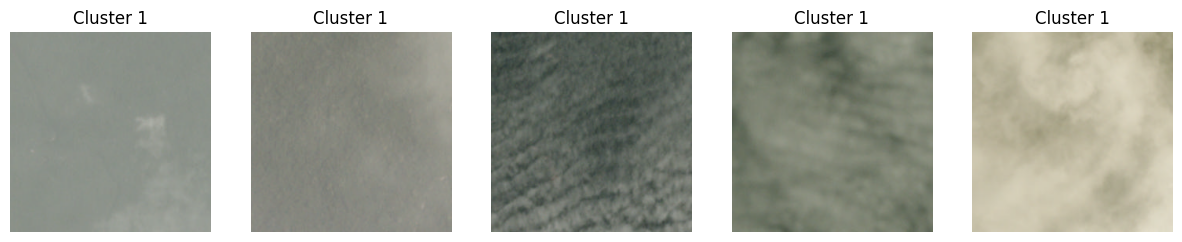

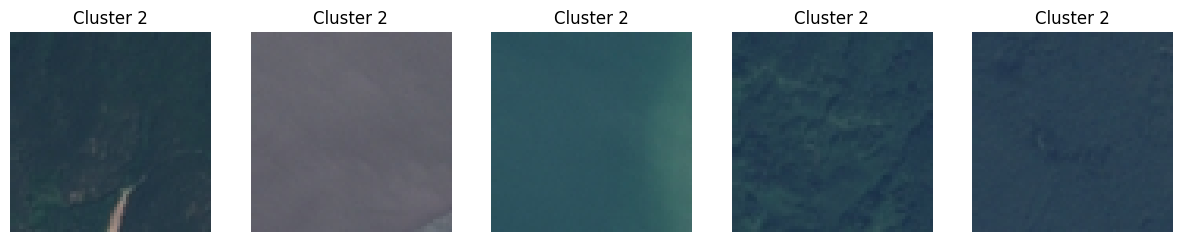

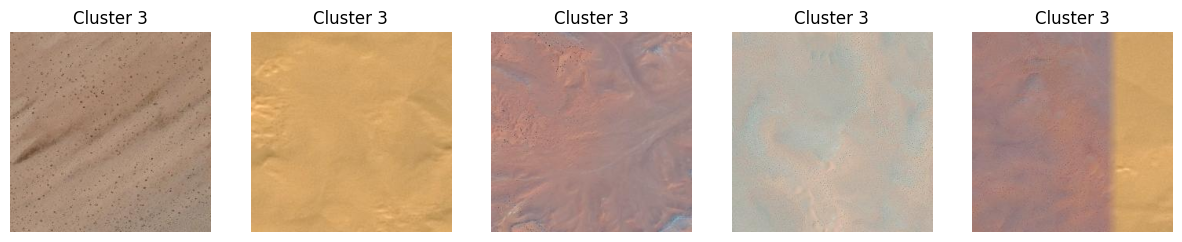

In [45]:
def display_cluster_images(cluster_labels, num_clusters, num_images=5):
    for cluster in range(num_clusters):
        plt.figure(figsize=(15, 3))
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        chosen_indices = random.sample(cluster_indices, min(len(cluster_indices), num_images))
        for i, idx in enumerate(chosen_indices):
            image_path = image_paths[idx]  # Correctly access the image path
            image = Image.open(image_path)
            plt.subplot(1, num_images, i + 1)  # Use 'i' for subplot indexing
            plt.imshow(image)
            plt.title(f"Cluster {cluster}")
            plt.axis('off')
        plt.show()

# Display images from each cluster
display_cluster_images(cluster_labels, num_clusters)
